In [1]:
import math, random
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Categorical
import pandas as pd

In [2]:
torch.manual_seed(51)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Data

In [5]:
apl_stock = pd.read_csv('/content/drive/Shareddrives/Machine Learning /project/AppleFinalData.csv')
msf_stock = pd.read_csv('/content/drive/Shareddrives/Machine Learning /project/MicrosoftFinalData.csv')
apl_open = apl_stock["Open"].values
apl_close = apl_stock["Close"].values
msf_open = msf_stock["Open"].values
msf_close = msf_stock["Close"].values

In [6]:
msf_stock.tail()

,Date,Open,High,Low,Close,Adj Close,compound,neg,neu,pos
2512,2016-11-23,61.01,61.10,60.25,60.40,60.40,0.8478,0.0,0.842,0.158
2513,2016-11-25,60.30,60.53,60.13,60.53,60.53,0.0000,0.0,0.000,0.000
2514,2016-11-28,60.34,61.02,60.21,60.61,60.61,0.0000,0.0,0.000,0.000
2515,2016-11-29,60.65,61.41,60.52,61.09,61.09,0.0000,0.0,0.000,0.000
2516,2016-11-30,60.86,61.18,60.22,60.26,60.26,0.0000,0.0,0.000,0.000


In [7]:
msf_stock.set_index("Date",drop=True,inplace=True)

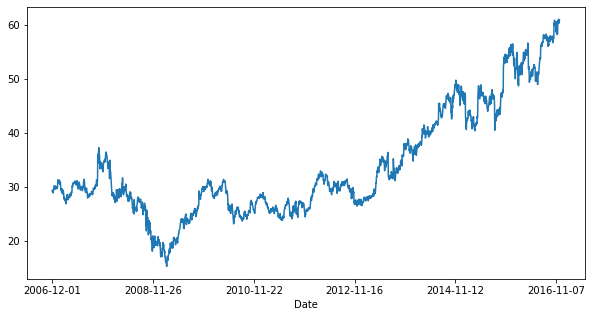

In [8]:
msf_stock['Open'].plot(figsize=(10,5))

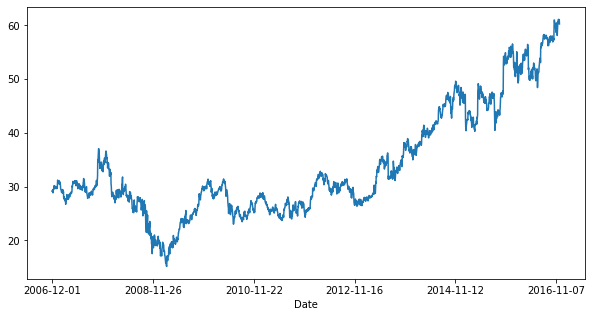

In [9]:
msf_stock['Close'].plot(figsize=(10,5))

In [10]:
apl_stock.set_index("Date",drop=True,inplace=True)

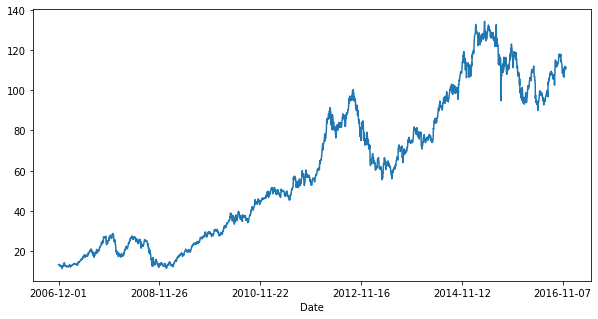

In [11]:
apl_stock['Open'].plot(figsize=(10,5))

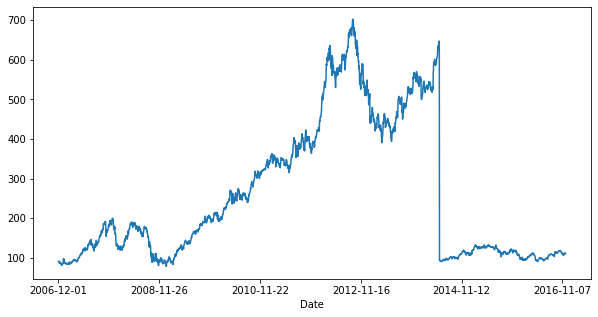

In [12]:
apl_stock['Close'].plot(figsize=(10,5))

In [13]:
#Correcting Apple stock error on 9th june

apl_stock['Close'].loc[:'2014-06-09'].iloc[:-1] /= 7

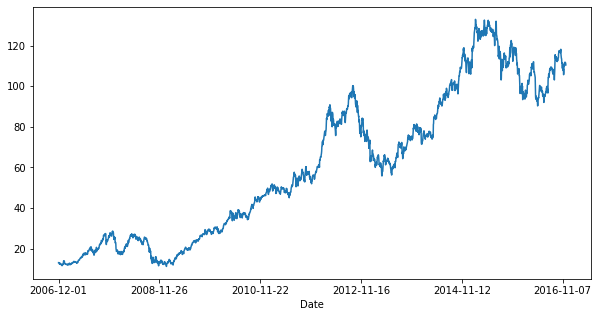

In [14]:
#Verifying the correctness
apl_stock['Close'].plot(figsize=(10,5))

In [15]:
apl_stock.head()

,Open,High,Low,Close,Adj Close,compound,neg,neu,pos
Date,,,,,,,,,
2006-12-01,13.1143,13.1900,12.8714,13.045714,13.0457,0.7707,0.032,0.905,0.063
2006-12-04,13.1257,13.1500,12.9286,13.017143,13.0171,0.8720,0.011,0.904,0.085
2006-12-05,13.0929,13.1900,12.9814,13.038571,13.0386,0.0000,0.000,0.000,0.000
2006-12-06,12.9486,13.0557,12.8100,12.832857,12.8329,0.6858,0.029,0.878,0.093
2006-12-07,12.8614,12.9286,12.4143,12.434286,12.4343,-0.6712,0.091,0.869,0.040


# Removing general upwards trend using scipy

In [16]:
from scipy import signal

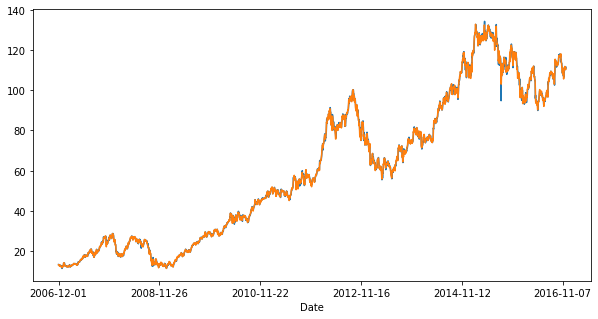

In [17]:
#Before detrend
apl_stock['Open'].plot(figsize=(10,5))
apl_stock['Close'].plot(figsize=(10,5))

In [18]:
apl_open = signal.detrend(apl_open)
apl_close = signal.detrend(apl_close)

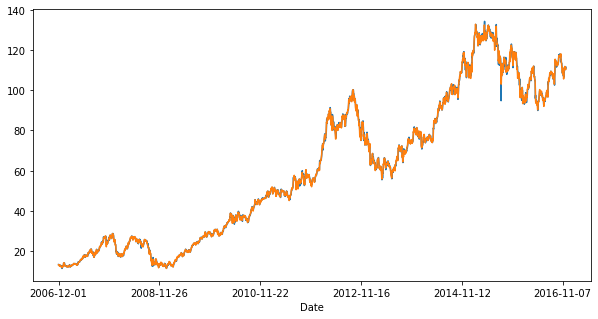

In [19]:
#After detrend
apl_stock['Open'].plot(figsize=(10,5))
apl_stock['Close'].plot(figsize=(10,5))

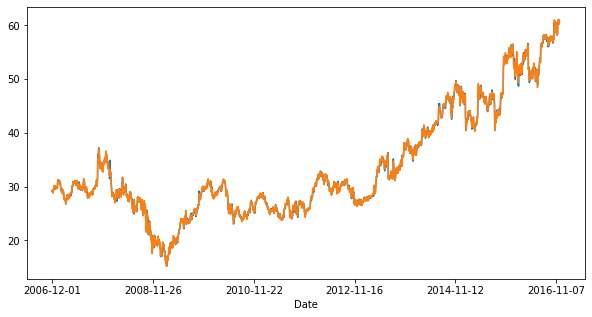

In [20]:
#Before detrend
msf_stock['Open'].plot(figsize=(10,5))
msf_stock['Close'].plot(figsize=(10,5))

In [21]:
msf_open = signal.detrend(msf_open)
msf_close = signal.detrend(msf_close)

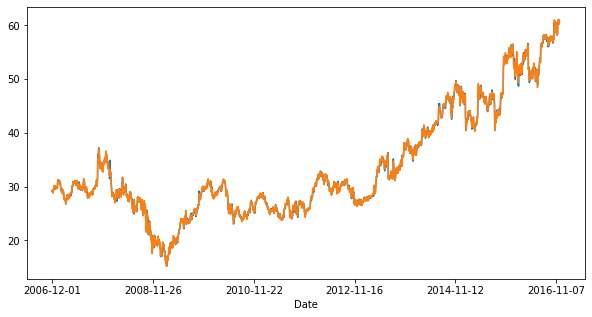

In [22]:
#After detrend
msf_stock['Open'].plot(figsize=(10,5))
msf_stock['Close'].plot(figsize=(10,5))

# Building the environment

In [23]:
import sys


* For starting cash, we can't use a dollar value because of the transformed data. After shifting earlier, we know the mean of each opening price should be 35, so I'm starting the agent off with enough cash to buy ~2.5 shares.
* This starting cash is the mean starting cash; it can be randomized by altering the std parameter
* action space = 0 buy apple, 1 sell apple, 2 do nothing, 3 buy msft, 4 sell msft, quantity. eg. [0, 100]
* obs space: apl shares, msft shares, cash in bank [2], today apl open [3], today msf open [4], portfolio value [5], 5 day window [6apl, 7msf] = 8
* If bot gets to the end with more than one of each share, we give it a bonus for having a diversified portfolio!
* Buys and sells attract a 10% brokerage fee

In [24]:
class TradingEnvironment():
#(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
    def __init__(self, starting_cash_mean=200., max_stride=5, series_length=208, starting_point=1, randomize_cash_std=0, 
                 starting_shares_mean=0., randomize_shares_std=0., inaction_penalty=0.):
        
        self.starting_shares_mean = starting_shares_mean
        self.randomize_shares_std = randomize_shares_std
        self.starting_cash_mean = starting_cash_mean
        self.randomize_cash_std = randomize_cash_std
        
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.series_length = series_length
        self.starting_point = starting_point
        self.cur_timestep = self.starting_point

        
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]
        #tensor([  91.0000,   97.0000,  886.0000,   11.4883,    9.5387, 1973.9983, 11.5239,    9.5498], device='cuda:0')
        
        self.max_stride = max_stride
        self.stride = self.max_stride # no longer varying it
        
        self.done = False
        self.diversification_bonus = 1.
        self.inaction_penalty = inaction_penalty
    
    def portfolio_value(self):
        return (self.state[0] * apl_close[self.cur_timestep]) + (self.state[1] * msf_close[self.cur_timestep]) + self.state[2]
    
    def next_opening_price(self):
        step = self.cur_timestep + self.stride
        return [apl_open[step], msf_open[step]]
    
    def five_day_window(self):
        step = self.cur_timestep
        if step < 5:
            return [apl_open[0], msf_open[0]]
        apl5 = apl_open[step-5:step].mean() #apl_open[3:8].mean() ->if step is 8
        msf5 = msf_open[step-5:step].mean()
        return [apl5, msf5]
    
    def step(self, action):
        action = [action, 1.]
        cur_timestep = self.cur_timestep
        ts_left = self.series_length - (cur_timestep - self.starting_point) # 208 - (1-1)
        retval = None
        cur_value = self.portfolio_value()
        gain = cur_value - self.starting_portfolio_value
        
        if cur_timestep >= self.starting_point + (self.series_length * self.stride):
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
            self.state = new_state
            bonus = 0.
            if self.state[0] > 0 and self.state[1] > 0:
                bonus = self.diversification_bonus
            return new_state, cur_value + bonus + gain, True, { "msg": "done"}
        
        if action[0] == 2:
            new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                    cur_value, *self.five_day_window()]
            self.state = new_state
            retval = new_state, -self.inaction_penalty-ts_left +gain, False, { "msg": "nothing" }
            
        if action[0] == 0:
            if action[1] * apl_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                apl_shares = self.state[0] + action[1]
                cash_spent = action[1] * apl_open[cur_timestep] * 1.1
                new_state = [apl_shares, self.state[1], self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought AAPL"}
                
        if action[0] == 3:
            if action[1] * msf_open[cur_timestep] > self.state[2]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval =  new_state, -ts_left+gain/2, True, { "msg": "bankrupted self"}
            else:
                msf_shares = self.state[1] + action[1]
                cash_spent = action[1] * msf_open[cur_timestep] * 1.1
                new_state = [self.state[0], msf_shares, self.state[2] - cash_spent, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "bought MSFT"}
        

        if action[0] == 1:
            if action[1] > self.state[0]:# 1> 90
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                apl_shares = self.state[0] - action[1]
                cash_gained = action[1] * apl_open[cur_timestep] * 0.9
                new_state = [apl_shares, self.state[1], self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold AAPL"}
                
        if action[0] == 4:
            if action[1] > self.state[1]:
                new_state = [self.state[0], self.state[1], self.state[2], *self.next_opening_price(), \
                        cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, -ts_left+gain/2, True, { "msg": "sold more than have"}
            else:
                msf_shares = self.state[1] - action[1]
                cash_gained = action[1] * msf_open[cur_timestep] * 0.9
                new_state = [self.state[0], msf_shares, self.state[2] + cash_gained, *self.next_opening_price(), \
                       cur_value, *self.five_day_window()]
                self.state = new_state
                retval = new_state, self.inaction_penalty-ts_left+gain, False, { "msg": "sold MSFT"}
                
        self.cur_timestep += self.stride
        return retval
    
    def reset(self):
        self.state = torch.FloatTensor(torch.zeros(8)).cuda()
        self.starting_cash = max(int(np.random.normal(self.starting_cash_mean, self.randomize_cash_std)), 0.)
        self.cur_timestep = self.starting_point
        self.state[0] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[1] = max(int(np.random.normal(self.starting_shares_mean, self.randomize_shares_std)), 0.)
        self.state[2] = self.starting_cash
        self.state[3] = apl_open[self.cur_timestep]
        self.state[4] = msf_open[self.cur_timestep]
        self.starting_portfolio_value = self.portfolio_value()
        self.state[5] = self.starting_portfolio_value
        self.state[6] = self.five_day_window()[0]
        self.state[7] = self.five_day_window()[1]       
        self.done = False
        return self.state

In [25]:
class Policy(nn.Module):
    print("HEREEEEE")
    def __init__(self):
        super(Policy, self).__init__()
        self.input_layer = nn.Linear(8, 128)
        self.hidden_1 = nn.Linear(128, 128)
        self.hidden_2 = nn.Linear(32,31)
        self.hidden_state = torch.tensor(torch.zeros(2,1,32),dtype=torch.float).cuda()
        self.rnn = nn.GRU(128, 32, 2)
        self.action_head = nn.Linear(31, 5)
        self.value_head = nn.Linear(31, 1)
        self.saved_actions = []
        self.rewards = []

    def reset_hidden(self):
        self.hidden_state = torch.tensor(torch.zeros(2,1,32),dtype=torch.float).cuda()
        
    def forward(self, x):
        x = torch.tensor(x,dtype=torch.float).cuda()
        x = torch.sigmoid(self.input_layer(x))
        x = torch.tanh(self.hidden_1(x))
        x, self.hidden_state = self.rnn(x.view(1,-1,128), self.hidden_state.data)
        x = F.relu(self.hidden_2(x.squeeze()))
        action_scores = self.action_head(x)
        state_values = self.value_head(x)
        return F.softmax(action_scores, dim=-1), state_values
    
    def act(self, state):
        
        probs, state_value = self.forward(state)
        m = Categorical(probs)
        action = m.sample()
        if action == 1 and env.state[0] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        if action == 4 and env.state[1] < 1: action = torch.LongTensor([2]).squeeze().cuda()
        self.saved_actions.append((m.log_prob(action), state_value))
        return action.item()

HEREEEEE


In [26]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
model = Policy().cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
env.reset()
# In case you're running this a second time with the same model, delete the gradients
del model.rewards[:]
del model.saved_actions[:]

gamma = 0.9
log_interval = 60

def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    rewards = []
    for r in model.rewards[::-1]:
        R = r + (gamma * R)
        rewards.insert(0, R)
    rewards = torch.tensor(rewards,dtype=torch.float)
    
    epsilon = (torch.rand(1) / 1e4) - 5e-5
    # With different architectures, I found the following standardization step sometimes
    # helpful, sometimes unhelpful.
    # rewards = (rewards - rewards.mean()) / (rewards.std(unbiased=False) + epsilon)
    # Alternatively, comment it out and use the following line instead:
    rewards += epsilon
    
    for (log_prob, value), r in zip(saved_actions, rewards):
        reward = torch.tensor(r - value.item(),dtype=torch.float).cuda()
        policy_losses.append(-log_prob * reward)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([r],dtype=torch.float).cuda()))
        
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss = torch.clamp(loss, -1e-5, 1e5)
    loss.backward()
    optimizer.step()
    del model.rewards[:]
    del model.saved_actions[:]


running_reward = 0
for episode in range(0, 4000):
    state = env.reset()
    reward = 0
    done = False
    msg = None
    while not done:
        action = model.act(state)
        state, reward, done, msg = env.step(action)
        model.rewards.append(reward)
        if done:
            break
    running_reward = running_reward * (1 - 1/log_interval) + reward * (1/log_interval)
    finish_episode()
    # Resetting the hidden state seems unnecessary - it's effectively random from the previous
    # episode anyway, more random than a bunch of zeros.
    # model.reset_hidden()
    if msg["msg"] == "done" and env.portfolio_value() > env.starting_portfolio_value * 1.1 and running_reward > 500:
        print("Early Stopping: " + str(int(reward)))
        break
    if episode % log_interval == 0:
        print("""Episode {}: started at {:.1f}, finished at {:.1f} because {} @ t={}, \
last reward {:.1f}, running reward {:.1f}""".format(episode, env.starting_portfolio_value, \
              env.portfolio_value(), msg["msg"], env.cur_timestep, reward, running_reward))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Episode 0: started at 2970.0, finished at -527.6 because done @ t=1001, last reward -4024.2, running reward -67.1
Episode 60: started at 3074.1, finished at -142.0 because done @ t=1001, last reward -3357.2, running reward -2218.9
Episode 120: started at 3723.0, finished at -339.9 because done @ t=1001, last reward -4401.8, running reward -3029.2
Episode 180: started at 3251.5, finished at -309.7 because done @ t=1001, last reward -3869.9, running reward -3375.5
Episode 240: started at 3024.7, finished at -114.1 because done @ t=1001, last reward -3251.9, running reward -3456.8
Episode 300: started at 2896.5, finished at -203.8 because done @ t=1001, last reward -3303.2, running reward -3491.4
Episode 360: started at 3176.9, finished at -191.0 because done @ t=1001, last reward -3557.9, running reward -3588.3
Episode 420: started at 3358.1, finished at -322.8 because done @ t=1001, last reward -4002.7, running reward -3563.4
Episode 480: started at 3136.4, finished at -222.2 because do

# Lets see how it does on the training data

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
total_rewards = 0
total_profits = 0
failed_goes = 0
num_goes = 50

for j in range(num_goes):
    env.reset()
    reward_this_go = -1e8
    for i in range(0,env.series_length + 1): 
        action = model.act(env.state)
        print(action)
        sys.exit(0)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == "done":
            reward_this_go = env.portfolio_value()
            break
        if done:
            break
    total_profits += (env.portfolio_value() - env.starting_portfolio_value) / env.starting_portfolio_value
    if reward_this_go == -1e8:
        failed_goes += 1
    else:
        total_rewards += reward_this_go

if failed_goes == num_goes:
    print("Failed all")
else:
    print("Failed goes: {} / {}, Avg Rewards per successful game: {}".format(failed_goes, num_goes, total_rewards / (num_goes - failed_goes)))
    print("Avg % profit per game: {}".format(total_profits / num_goes))
    print("Avg % profit per finished game: {}".format(total_profits / (num_goes - failed_goes)))

# Sample trading run

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
print("starting portfolio value {}".format(env.portfolio_value()))
for i in range(0,env.series_length + 1):
    action = model.act(env.state)
    next_state, reward, done, msg = env.step(action)
    if msg["msg"] == 'bankrupted self':
        print('bankrupted self by 1')
        break
    if msg["msg"] == 'sold more than have':
        print('sold more than have by 1')
        break
    print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
    if msg["msg"] == "done":
        print(next_state, reward)
        print("total portfolio value {}".format(env.portfolio_value()))
        break

In [ ]:
apl_open_orig = apl_stock["Open"].values
apl_close_orig = apl_stock["Close"].values
msf_open_orig = msf_stock["Open"].values
msf_close_orig = msf_stock["Close"].values
apl_close_orig[:108] /= 7

In [ ]:
env = TradingEnvironment(max_stride=4, series_length=250, starting_cash_mean=1000, randomize_cash_std=100, starting_shares_mean=100, randomize_shares_std=10)
env.reset()
complete_game = False
while not complete_game:
    bought_apl_at = []
    bought_msf_at = []
    sold_apl_at = []
    sold_msf_at = []
    bought_apl_at_orig = []
    bought_msf_at_orig = []
    sold_apl_at_orig = []
    sold_msf_at_orig = []
    nothing_at = []
    ba_action_times = []
    bm_action_times = []
    sa_action_times = []
    sm_action_times = []
    n_action_times = []
    starting_val = env.starting_portfolio_value
    print("Starting portfolio value: {}".format(starting_val))
    for i in range(0,env.series_length + 1):
        action = model.act(env.state)
        if action == 0:
            bought_apl_at.append(apl_open[env.cur_timestep])
            bought_apl_at_orig.append(apl_open_orig[env.cur_timestep])
            ba_action_times.append(env.cur_timestep)
        if action == 1:
            sold_apl_at.append(apl_close[env.cur_timestep])
            sold_apl_at_orig.append(apl_close_orig[env.cur_timestep])
            sa_action_times.append(env.cur_timestep)
        if action == 2:
            nothing_at.append(35)
            n_action_times.append(env.cur_timestep)
        if action == 3:
            bought_msf_at.append(msf_open[env.cur_timestep])
            bought_msf_at_orig.append(msf_open_orig[env.cur_timestep])
            bm_action_times.append(env.cur_timestep)
        if action == 4:
            sold_msf_at.append(msf_close[env.cur_timestep])
            sold_msf_at_orig.append(msf_close_orig[env.cur_timestep])
            sm_action_times.append(env.cur_timestep)
        next_state, reward, done, msg = env.step(action)
        if msg["msg"] == 'bankrupted self':
            env.reset()
            break
        if msg["msg"] == 'sold more than have':
            env.reset()
            break
        if msg["msg"] == "done":
            print("{}, have {} aapl and {} msft and {} cash".format(msg["msg"], next_state[0], next_state[1], next_state[2]))
            val = env.portfolio_value()
            print("Finished portfolio value {}".format(val))
            if val > starting_val * 1.1: complete_game = True
            env.reset()
            break